<a href="https://colab.research.google.com/github/Waidhoferj/CSC-566-Project/blob/heatmaps/FacialLandmarks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial Landmarks
Experimentation with facial landmarks models and datasets.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from google.colab import drive
import os
from scipy.io import loadmat
import random

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Add your name and filepath to the project folder so that you can load the datasets.


In [3]:
USER = "Jeremy"
USER_FILEPATHS = {
    "John" : "/content/drive/MyDrive/CSC 566 Project",
    "Jeremy" : "/content/drive/MyDrive/School/Undergrad/2021 Spring/CSC 566/CSC 566 Project",
    "Ty" : "/content/drive/MyDrive/CSC 566 Project"
}
PROJECT_FILEPATH = USER_FILEPATHS[USER]

## Data Preparation

In [4]:
# Sanity check for loading data
def display_landmarks(img, points):
  """
  Displays portrait with landmark dots drawn on the face.
  Assumes that points are in (68,2)
  """
  #If we are reading from .mat files directly (2,68)
  if points.shape[0] == 2:
    points = points.transpose(1,0)
  #If reading from model output
  elif len(points.shape) == 1:
    points = points.reshape(-1,2)
  fig,ax = plt.subplots(1)
  ax.set_aspect('equal')
  ax.imshow(img)
  for p in points:
      circ = Circle(p)
      ax.add_patch(circ)
  plt.show()

#points = loadmat(AFW_DATASET + "/70037463_1.mat")["pt2d"]
#img  = plt.imread( AFW_DATASET+"/70037463_1.jpg")

#display_landmarks(img,points)



In [5]:
import tensorflow as tf

USE_CROPPED_IMAGES = True
USE_HEATMAPS = False

DATALOADER_BASE_PATH = PROJECT_FILEPATH + "/datasets/tf-datasets"
DATASET_PREFIX = "cropped-" if USE_CROPPED_IMAGES else ""

class DataLoader:

  IMAGE_SHAPE = (256, 256, 3) if USE_CROPPED_IMAGES else (450, 450, 3)
  LANDMARKS_SHAPE = (136,)

  HEATMAP_SHAPE = (128, 128)
  HEATMAP_POINT_RADIUS = 0.15

  BATCH_SIZE = 16
  TRAIN_PATHS = [f"{DATALOADER_BASE_PATH}/{DATASET_PREFIX}train-{i}.tfrecord.gz" for i in range(5)]
  VAL_PATHS = [f"{DATALOADER_BASE_PATH}/{DATASET_PREFIX}val-{i}.tfrecord.gz" for i in range(5)]
  TEST_PATHS = [f"{DATALOADER_BASE_PATH}/{DATASET_PREFIX}test-{i}.tfrecord.gz" for i in range(5)]

  def load_datasets():
    dl = DataLoader()
    return (dl.__load_dataset(DataLoader.TRAIN_PATHS, DataLoader.BATCH_SIZE),
            dl.__load_dataset(DataLoader.VAL_PATHS, DataLoader.BATCH_SIZE),
            dl.__load_dataset(DataLoader.TEST_PATHS, 1))

  def __load_dataset(self, filepath, batch_size):
    dataset = tf.data.TFRecordDataset([filepath], compression_type="GZIP")
    dataset = dataset.map(self.__parse_example, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(self.__reshape_entry, num_parallel_calls=tf.data.AUTOTUNE)

    if USE_HEATMAPS:
      imagesToHeatmapsDataset, heatmapsToPointsDataset = self.__convert_to_heatmaps(dataset, batch_size)
      imagesToHeatmapsDataset.cache()
      heatmapsToPointsDataset.cache()
      return imagesToHeatmapsDataset, heatmapsToPointsDataset
    else:
      images = dataset.map(lambda x,y: x, num_parallel_calls=tf.data.AUTOTUNE)
      labels = dataset.map(lambda x,y: y, num_parallel_calls=tf.data.AUTOTUNE)
      images = images.batch(batch_size)
      labels = labels.batch(batch_size)
      dataset = tf.data.Dataset.zip((images, labels))
      dataset.cache() # Cache the above map operations so they aren't re-run every epoch
    return dataset


  def __parse_example(self, record):
    feature_names = {}
    feature_names['image'] = tf.io.FixedLenSequenceFeature([],tf.float32, allow_missing=True)
    feature_names['landmarks'] = tf.io.FixedLenSequenceFeature([],tf.float32, allow_missing=True)
    return tf.io.parse_single_example(record, feature_names)

  def __reshape_entry(self, entry):
    image = tf.reshape(entry['image'], DataLoader.IMAGE_SHAPE)
    landmarks = tf.reshape(entry['landmarks'], DataLoader.LANDMARKS_SHAPE)
    return image, landmarks

  def __convert_to_heatmaps(self, dataset, batch_size):
    images = dataset.map(lambda x,y: x, num_parallel_calls=tf.data.AUTOTUNE)
    labels = dataset.map(lambda x,y: y, num_parallel_calls=tf.data.AUTOTUNE)

    heatmaps = labels.map(self.__convert_label_to_heatmap, num_parallel_calls=tf.data.AUTOTUNE)
    heatmaps = heatmaps.batch(batch_size)

    imagesToHeatmaps = tf.data.Dataset.zip((images.batch(batch_size), heatmaps))
    heatmapsToPoints = tf.data.Dataset.zip((heatmaps, labels.batch(batch_size)))

    return imagesToHeatmaps, heatmapsToPoints

  @tf.autograph.experimental.do_not_convert
  def __convert_label_to_heatmap(self, label):
    heatmap = tf.zeros(DataLoader.HEATMAP_SHAPE)
    coords = tf.range(DataLoader.HEATMAP_SHAPE[0]*DataLoader.HEATMAP_SHAPE[1], dtype=tf.float32)
    coords = tf.reshape(coords, DataLoader.HEATMAP_SHAPE)
    for i in range(0, 68):
      heatmap += self.__add_point_to_heatmap(coords, label[2*i], label[2*i+1])
    return heatmap

  @tf.autograph.experimental.do_not_convert
  def __add_point_to_heatmap(self, coords, x, y):
    return tf.map_fn(fn=lambda i: self.__heatmap_point_dist(i, x, y, coords.shape[0], coords.shape[1]), elems=coords)

  @tf.autograph.experimental.do_not_convert
  def __heatmap_point_dist(self, i, x, y, w, h):
    ix = (i%h)/w
    iy = (i//h)/h
    radius = DataLoader.HEATMAP_POINT_RADIUS
    dist = tf.sqrt((x-ix)**2 + (y-iy)**2)
    return tf.math.minimum(1.0, tf.math.maximum(0.0, 1.0 - (1/radius)*dist))


train_data, val_data, test_data = DataLoader.load_datasets()

#val_1st, val_2nd = val_data
#
#for i,record in enumerate(val_2nd):
#  print(record[0].shape, record[1].shape)
#  plt.gray()
#  plt.imshow(record[0][0])
#  break

# Heatmap To Landmarks CNN


In [7]:
def create_heatmap_to_points_cnn(input_shape, output_shape):
  input_layer = layers.Input(input_shape)
  x = input_layer

  x = layers.Reshape((input_shape[0], input_shape[1], 1))(x)

  features = 16
  for i in range(4):
    x = layers.Conv2D(features, (3,3), 1, activation="relu")(x)
    x = layers.MaxPool2D(padding="same")(x)
    features *= 2

  x = layers.Flatten()(x)
  x = layers.Dense(512, activation="relu")(x)
  x = layers.Dense(output_shape[0], activation="relu")(x)
  return Model(name="heatmap_to_landmarks", inputs=input_layer, outputs=x)


heatmap_to_points_model = create_heatmap_to_points_cnn(DataLoader.HEATMAP_SHAPE, DataLoader.LANDMARKS_SHAPE)
heatmap_to_points_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01), loss="mse", metrics=["loss"])
heatmap_to_points_model.summary()

Model: "heatmap_to_landmarks"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128)]        0         
_________________________________________________________________
reshape (Reshape)            (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 126, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
_, train_ds = train_data
_, val_ds = val_data

#for i,record in enumerate(train_ds):
#  print(record[0].shape, record[1].shape)
#  plt.gray()
#  plt.imshow(record[0][0])
#  break

heatmap_to_points_model.fit(train_ds.shuffle(8), epochs=30, validation_data=val_ds, verbose=1)

Epoch 1/30
204/204 [==============================] - 415s 2s/step - loss: 661.5781 - accuracy: 0.3145 - val_loss: 0.3796 - val_accuracy: 0.0000e+00
Epoch 2/30
204/204 [==============================] - 410s 2s/step - loss: 0.6332 - accuracy: 0.4178 - val_loss: 0.3681 - val_accuracy: 0.5760
Epoch 3/30
204/204 [==============================] - 417s 2s/step - loss: 0.5689 - accuracy: 0.4437 - val_loss: 0.3635 - val_accuracy: 0.5240
Epoch 4/30
204/204 [==============================] - 414s 2s/step - loss: 0.5674 - accuracy: 0.4548 - val_loss: 0.3416 - val_accuracy: 0.5800
Epoch 5/30
204/204 [==============================] - 402s 2s/step - loss: 0.5441 - accuracy: 0.5680 - val_loss: 0.3367 - val_accuracy: 0.6240
Epoch 6/30
204/204 [==============================] - 399s 2s/step - loss: 0.5378 - accuracy: 0.5791 - val_loss: 0.3328 - val_accuracy: 0.6240
Epoch 7/30
204/204 [==============================] - 402s 2s/step - loss: 0.5373 - accuracy: 0.5655 - val_loss: 0.3311 - val_accuracy: 

KeyboardInterrupt: ignored

In [ ]:
heatmap_to_points_model.evaluate(test_data[1])

443/443 [==============================] - 104s 223ms/step - loss: 0.4050 - accuracy: 0.5734


[0.4050385057926178, 0.5733634233474731]

In [ ]:
heatmap_to_points_model.save_weights(PROJECT_FILEPATH + "/heatmap-to-points-model.h5")

## Basic Benchmark Model
From [this medium article](https://towardsdatascience.com/detecting-facial-features-using-deep-learning-2e23c8660a7a)

In [6]:
def create_basic_landmark_model(input_shape, conv_range):
  input_layer = layers.Input(input_shape)
  x = input_layer
  for exp in conv_range:
    x = layers.Conv2D(2**exp, (3,3), 3, activation="relu")(x)
    x = layers.MaxPool2D(padding="same")(x)
  x = layers.Flatten()(x)
  x = layers.Dense(500, activation="relu")(x)
  x = layers.Dense(90, activation="relu")(x)
  x = layers.Dense(68*2, activation="relu")(x)
  return Model(name="landmark_locator", inputs=input_layer, outputs=x)



In [7]:
INPUT_SHAPE = (256,256,3)
basic_model = create_basic_landmark_model(INPUT_SHAPE, range(5,8))
basic_model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
basic_model.summary()

Model: "landmark_locator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 85, 85, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 128)    

In [8]:
basic_model.fit(train_data.shuffle(16), epochs=40, validation_data=val_data, verbose=1)

Epoch 1/40
102/102 [==============================] - 17s 125ms/step - loss: 0.8969 - accuracy: 0.0868 - val_loss: 0.6955 - val_accuracy: 0.1600
Epoch 2/40
102/102 [==============================] - 15s 127ms/step - loss: 0.8638 - accuracy: 0.1188 - val_loss: 0.6907 - val_accuracy: 0.1600
Epoch 3/40
102/102 [==============================] - 15s 125ms/step - loss: 0.8434 - accuracy: 0.1163 - val_loss: 0.6608 - val_accuracy: 0.1600
Epoch 4/40
102/102 [==============================] - 15s 124ms/step - loss: 0.8264 - accuracy: 0.1360 - val_loss: 0.6426 - val_accuracy: 0.1280
Epoch 5/40
102/102 [==============================] - 14s 124ms/step - loss: 0.8149 - accuracy: 0.1397 - val_loss: 0.6729 - val_accuracy: 0.1200
Epoch 6/40
102/102 [==============================] - 14s 123ms/step - loss: 0.8174 - accuracy: 0.1243 - val_loss: 0.6360 - val_accuracy: 0.1600
Epoch 7/40
102/102 [==============================] - 14s 123ms/step - loss: 0.8250 - accuracy: 0.1138 - val_loss: 0.6421 - val_ac

In [10]:
basic_model.save_weights(PROJECT_FILEPATH + "/basic-model.h5")

### Analyze Results

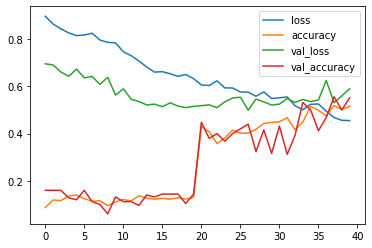

In [9]:
pd.DataFrame(basic_model.history.history).plot()

In [ ]:
predictions = basic_model.predict(test_data.map(lambda x,y: x))

In [ ]:
#@title View Predicted Images
image_index = 3 #@param {type:"slider", min:1, max:16, step:1}
points = predictions * 450
i = 0
for x in test_data.map(lambda x,y: x):
  if (i == image_index):
    display_landmarks(tf.reshape(x, DataLoader.IMAGE_SHAPE), points[image_index])
    break
  i += 1